# Proyecto: Visualización 3D de modelo de exposición

Github: [Github del proyecto](https://github.com/drodrguez/Visualizacion3D/)

## Descripción del proyecto

Este proyecto tiene como objetivo investigar e implementar metodologías novedosas de visualización de datos de exposición a distintas escalas espaciales, que permitan representar y comunicar de manera atractiva la información contenida en ellos, como ubicación, altura, densidad, materialidad, tipo de uso, edad, tipología estructural, etc.

## Datos disponibles

- Modelo de exposición: Los datos principales de este proyecto corresponde al modelo de exposición producto de la publicación "Development of national and local exposure models of residential structures in Chile". Este modelo se constituye de 1 archivo .txt para cada región, que incluye un catastro a nivel de bloque censal para 18 tipologías distintas de estructuras. 

- Datos de salud pública: Se obtienen directamente desde el MINSAL. Estos datos presentan el desafío de que son actualizados constantemente, por lo que su url es variable. Se debe pensar en como solucionar este problema.

- Datos de educación: Obtenidos desde la página de datos abiertos del [MINEDUC](http://datosabiertos.mineduc.cl/). Estos presentan el desafío de que su formato es en .rar, formato que es dificil de abordar desde la automatización, pues WinRar es un producto de licencia y no open-source.

- Datos de cartografía censal: Obtenidos desde la página del [censo](http://www.censo2017.cl/servicio-de-mapas/). Presenta el mismo problema: vienen en formato .rar.


## Carga de los datos.

### Modelo de exposición. 

Los modelos de exposición se encuentran en formato .txt, y deben ser transformados a un formato adecuado para el trabajo de datos geoespaciales. Esto se realiza a través de pandas y los métodos implementados en geopandas, que nos permiten obtener la geometría directamente desde un dataset.

In [1]:
import pandas as pd
import geopandas as gpd

In [12]:
# Obtenemos los path de los modelos de exposición por región almacenados en el github del proyecto.

exposure_paths = ["https://raw.githubusercontent.com/drodrguez/Visualizacion3D/main/Datos/Exposure_model/Exposure%20Model%20Block%20Reg%20"+str(num)+"_opt.txt" for num in range(1, 16) if num!= 13]
capital_exposure = ["https://raw.githubusercontent.com/drodrguez/Visualizacion3D/main/Datos/Exposure_model/ExposureModelBlockReg_13_"+str(num)+"_opt.txt" for num in range(1, 4)]
exposure_paths = exposure_paths + capital_exposure

In [32]:
exposure_geodata = dict()
capital = []
for path in exposure_paths:    
    data = pd.read_csv(path, encoding='latin-1')
    reg_id = data.region_id[0]
    if reg_id == 13:
        capital.append(data)
    else:
        geodata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.latitude, data.longitude))          
        exposure_geodata[geodata.region_id[0]] = geodata
    
capital_data = pd.concat([data for data in capital])
geodata = gpd.GeoDataFrame(capital_data, geometry=gpd.points_from_xy(capital_data.latitude, capital_data.longitude)) 
exposure_geodata[13] = geodata

<AxesSubplot:>

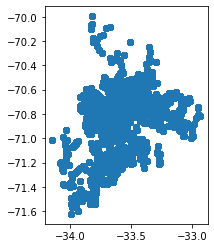

In [35]:
exposure_geodata[13].plot()

In [36]:
exposure_geodata[13].columns

Index(['longitude', 'latitude', 'region_id', 'region_name', 'municipality_id',
       'municipality_name', 'census_block', 'typology', 'number_dwellings',
       'number_buildings', 'avg_dwellings_per_building', 'avg_number_storeys',
       'avg_floor_area_dwelling(m2)', 'avg_floor_area_building(m2)',
       'total_area(m2)', 'replace_cost_per_building_area(USD/m2)',
       'replace_cost_per_building_area(LocalCurrency/m2)',
       'replace_cost_per_building(USD)',
       'replace_cost_per_building(LocalCurrency)', 'total_replace_cost(USD)',
       'total_replace_cost(LocalCurrency)', 'occupants_per_dwelling',
       'occupants_per_building', 'total_occupants', 'is_urban', 'geometry'],
      dtype='object')

In [48]:
exposure_geodata[13].query('census_block == 13605992008001')

,longitude,latitude,region_id,region_name,municipality_id,municipality_name,census_block,typology,number_dwellings,number_buildings,...,replace_cost_per_building_area(LocalCurrency/m2),replace_cost_per_building(USD),replace_cost_per_building(LocalCurrency),total_replace_cost(USD),total_replace_cost(LocalCurrency),occupants_per_dwelling,occupants_per_building,total_occupants,is_urban,geometry
127127,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,1,1.01,1.01,...,NaN,71280.99,NaN,72314.07,NaN,3.39,3.39,3.44,False,POINT (-33.61088 -70.89364)
127128,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,2,0.43,0.01,...,NaN,502900.99,NaN,6118.28,NaN,3.19,113.85,1.39,False,POINT (-33.61088 -70.89364)
127129,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,3,0.54,0.00,...,NaN,5360506.24,NaN,17529.45,NaN,3.19,525.12,1.72,False,POINT (-33.61088 -70.89364)
127130,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,5,11.00,11.00,...,NaN,45751.60,NaN,503373.79,NaN,3.61,3.61,39.68,False,POINT (-33.61088 -70.89364)
127131,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,6,9.55,9.55,...,NaN,26946.65,NaN,257361.95,NaN,3.61,3.61,34.45,False,POINT (-33.61088 -70.89364)
127132,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,9,0.01,0.00,...,NaN,237845.51,NaN,187.28,NaN,3.45,37.93,0.03,False,POINT (-33.61088 -70.89364)
127133,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,12,0.57,0.02,...,NaN,483659.83,NaN,7327.45,NaN,3.45,128.74,1.95,False,POINT (-33.61088 -70.89364)
127134,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,7,4.96,4.96,...,NaN,36349.13,NaN,180216.80,NaN,3.61,3.61,17.88,False,POINT (-33.61088 -70.89364)
127135,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,10,0.05,0.00,...,NaN,246828.94,NaN,453.49,NaN,3.45,95.03,0.17,False,POINT (-33.61088 -70.89364)
127136,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,13,0.41,0.01,...,NaN,513988.58,NaN,7052.64,NaN,3.45,101.91,1.40,False,POINT (-33.61088 -70.89364)


In [46]:
2.93*0.31

0.9083

In [47]:
exposure_geodata[13]

,longitude,latitude,region_id,region_name,municipality_id,municipality_name,census_block,typology,number_dwellings,number_buildings,...,replace_cost_per_building_area(LocalCurrency/m2),replace_cost_per_building(USD),replace_cost_per_building(LocalCurrency),total_replace_cost(USD),total_replace_cost(LocalCurrency),occupants_per_dwelling,occupants_per_building,total_occupants,is_urban,geometry
0,-70.63756,-33.43581,13,Region Metropolitana,13101,Santiago,13101011001002,1,0.31,0.31,...,NaN,41646.56,NaN,13006.92,NaN,2.93,2.93,0.91,True,POINT (-33.43581 -70.63756)
1,-70.63756,-33.43581,13,Region Metropolitana,13101,Santiago,13101011001002,2,9.01,0.11,...,NaN,2366932.21,NaN,265499.02,NaN,1.95,156.26,17.53,True,POINT (-33.43581 -70.63756)
2,-70.63756,-33.43581,13,Region Metropolitana,13101,Santiago,13101011001002,3,48.18,0.22,...,NaN,6327080.83,NaN,1386948.00,NaN,1.95,427.67,93.75,True,POINT (-33.43581 -70.63756)
3,-70.63756,-33.43581,13,Region Metropolitana,13101,Santiago,13101011001002,4,28.17,0.08,...,NaN,9503050.08,NaN,787276.10,NaN,1.95,661.62,54.81,True,POINT (-33.43581 -70.63756)
4,-70.63756,-33.43581,13,Region Metropolitana,13101,Santiago,13101011001002,5,0.13,0.13,...,NaN,48037.54,NaN,6374.48,NaN,3.20,3.20,0.42,True,POINT (-33.43581 -70.63756)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127136,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,13,0.41,0.01,...,NaN,513988.58,NaN,7052.64,NaN,3.45,101.91,1.40,False,POINT (-33.61088 -70.89364)
127137,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,8,0.11,0.11,...,NaN,20161.43,NaN,2260.83,NaN,3.61,3.61,0.40,False,POINT (-33.61088 -70.89364)
127138,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,15,7.49,7.49,...,NaN,23840.86,NaN,178633.70,NaN,3.60,3.60,26.98,False,POINT (-33.61088 -70.89364)
127139,-70.89364,-33.61088,13,Región Metropolitana,13605,Peñaflor,13605992008001,16,0.04,0.04,...,NaN,1280.00,NaN,55.65,NaN,3.15,3.15,0.14,False,POINT (-33.61088 -70.89364)
